In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import kaggle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Helper functions

In [27]:
def get_float_cols(df:DataFrame):
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame):
    return df.select_dtypes(include=int).columns.tolist()

def get_obj_cols(df:DataFrame):
    return list(df.select_dtypes(include=object).columns)


In [6]:
def plot_hist_float(df:DataFrame):
    df_numeric = df[get_float_cols(df)]
    df_numeric.hist(bins=100, figsize=(30,20))
    plt.show()

In [7]:
def plot_hist_int(df:DataFrame):
    df_numeric = df[get_int_cols(df)]
    df_numeric.hist(bins=100, figsize=(30,20))
    plt.show()

In [8]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test.drop(['ind'])
    train.drop(['ind'])
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    return combine

In [9]:
def print_empty_values(df:DataFrame) -> DataFrame:
    col_names_with_na = list(df.isna().sum()[lambda x: x > 0].index)
    col_names_with_empty = list(df.isnull().sum()[lambda x: x > 0].index)
    print('Columns with NA: {0}'.format(col_names_with_na))
    print('Columns with empty {0}'.format(col_names_with_empty))
    return col_names_with_na, col_names_with_empty

In [10]:
df_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
df_combine = combine_test_train(df_test, df_train)

In [28]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Building pipeline

In [ ]:
class Pipe:
    def __init__(self, funcs, **kwargs):
        self.funcs = funcs
        self.kwargs = kwargs
    
    def transform(self, df:DataFrame) -> DataFrame:
        for f in self.funcs:
            df = f(df, **self.kwargs)
            
        return df.copy()

## Plotting

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

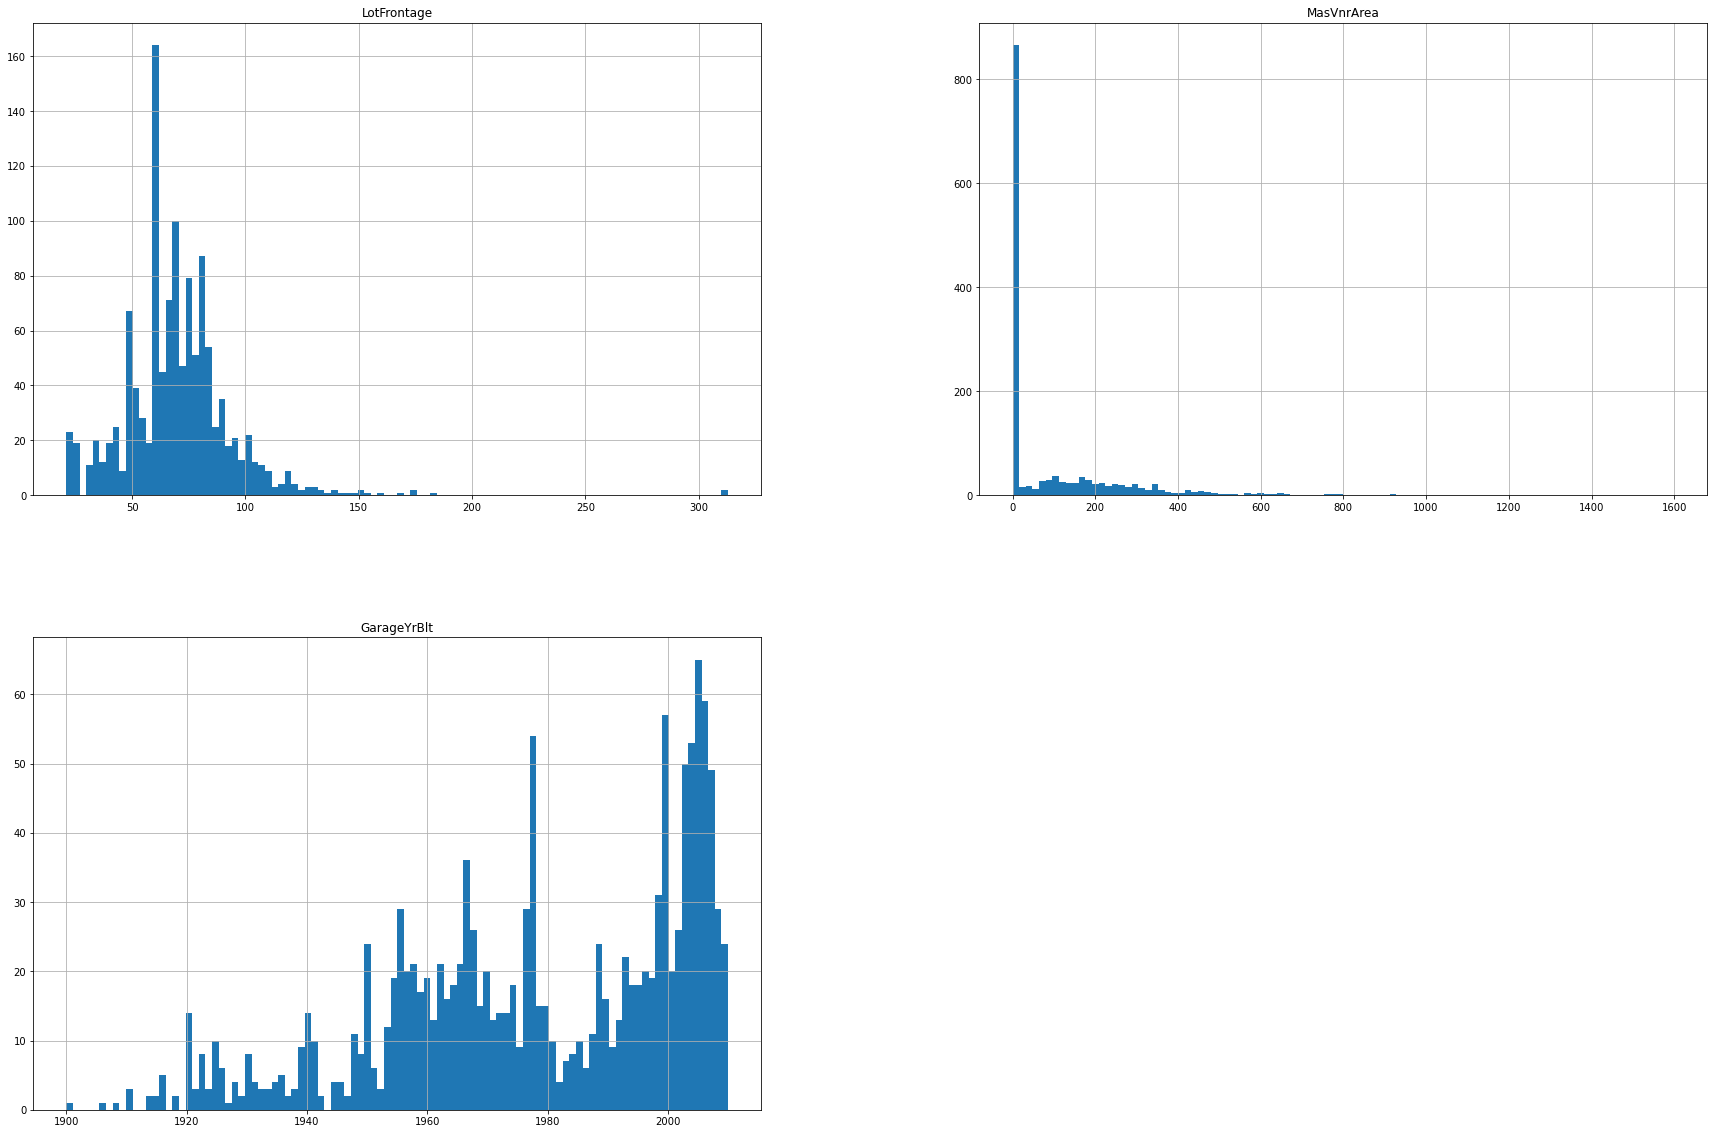

In [13]:
plot_hist_float(df_train)

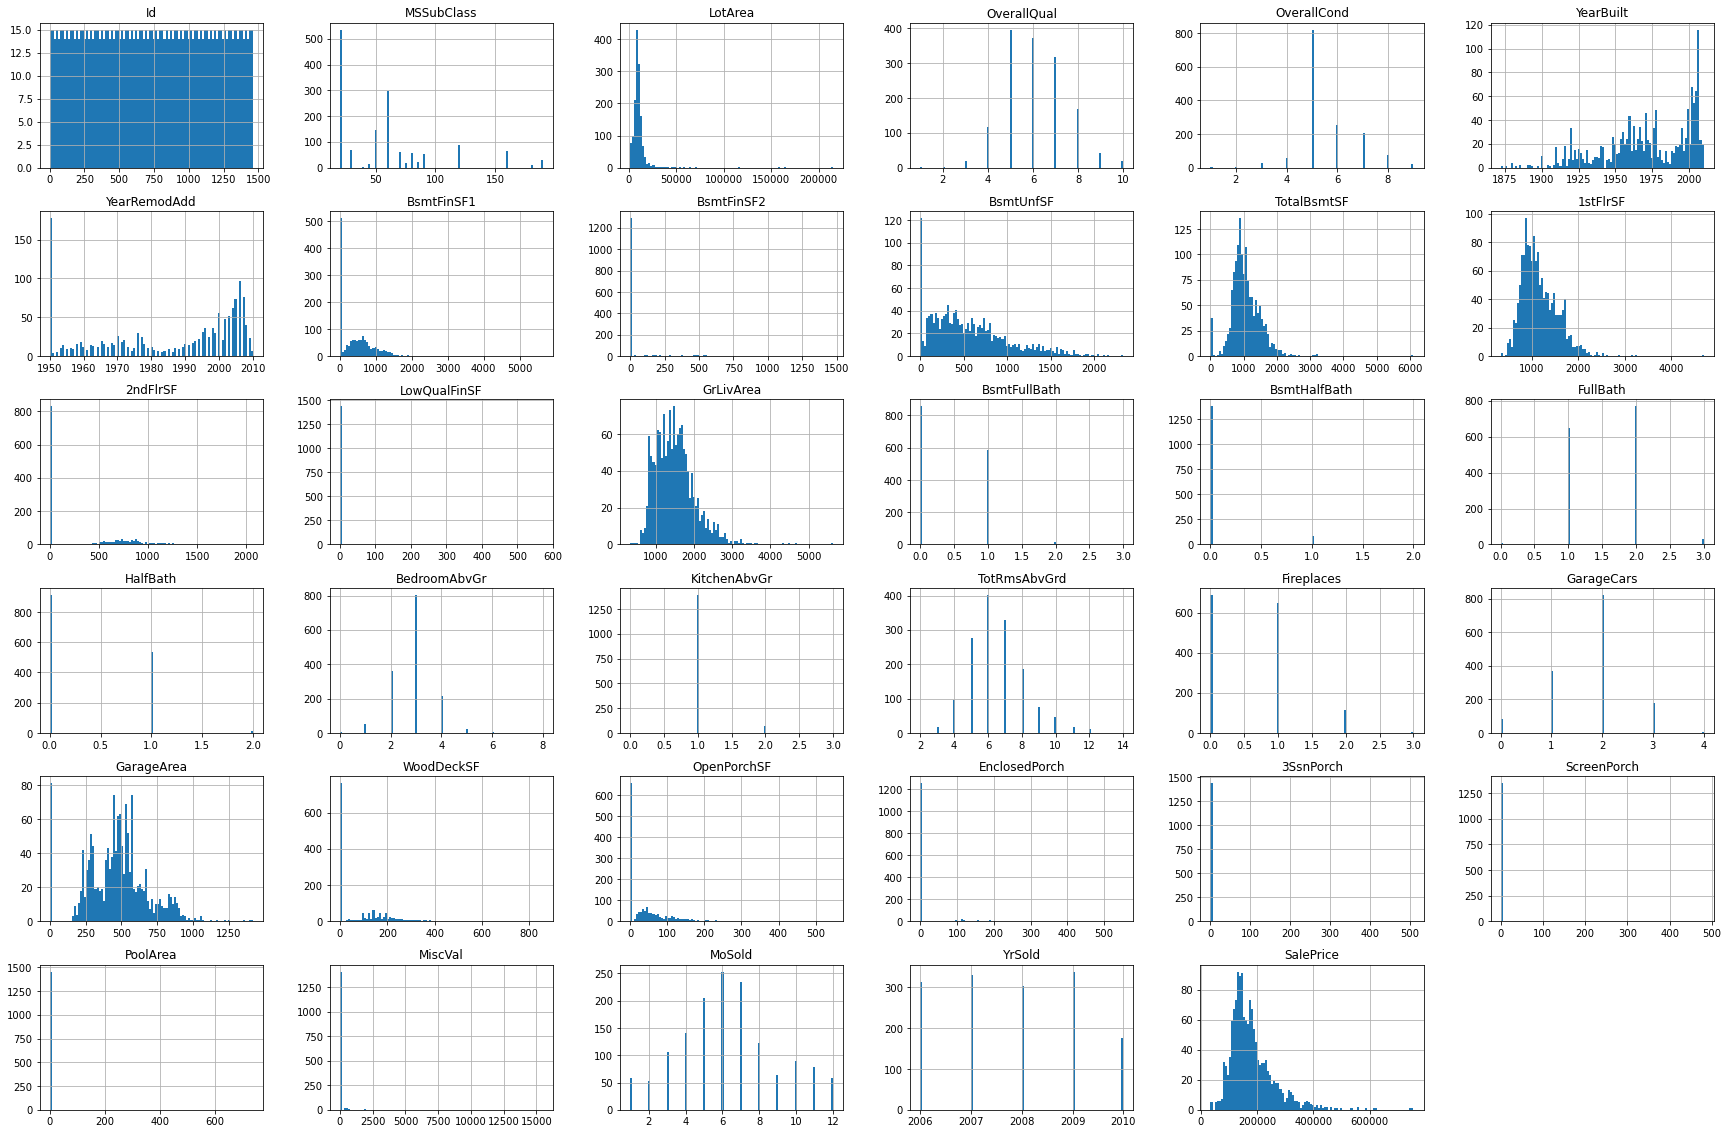

In [14]:
plot_hist_int(df_train)

In [25]:
obj_cols = get_obj_cols(df_combine)
na_as_val_cols = ()


for col in obj_cols:
    possible_vals = [(str(s)).lower() for s in list(df_combine[col].unique())]
    print("{0} -> Possible: {1}".format(col, possible_vals))
    if ('na' in possible_vals):
        na_as_val_cols.append(col)
        
print(na_as_val_cols)

MSZoning -> Possible: ['rh', 'rl', 'rm', 'fv', 'c (all)', 'nan']
Street -> Possible: ['pave', 'grvl']
Alley -> Possible: ['nan', 'pave', 'grvl']
LotShape -> Possible: ['reg', 'ir1', 'ir2', 'ir3']
LandContour -> Possible: ['lvl', 'hls', 'bnk', 'low']
Utilities -> Possible: ['allpub', 'nan', 'nosewa']
LotConfig -> Possible: ['inside', 'corner', 'fr2', 'culdsac', 'fr3']
LandSlope -> Possible: ['gtl', 'mod', 'sev']
Neighborhood -> Possible: ['names', 'gilbert', 'stonebr', 'brdale', 'npkvill', 'nridght', 'blmngtn', 'noridge', 'somerst', 'sawyerw', 'sawyer', 'nwames', 'oldtown', 'brkside', 'clearcr', 'swisu', 'edwards', 'collgcr', 'crawfor', 'blueste', 'idotrr', 'mitchel', 'timber', 'meadowv', 'veenker']
Condition1 -> Possible: ['feedr', 'norm', 'posn', 'rrne', 'artery', 'rrnn', 'posa', 'rran', 'rrae']
Condition2 -> Possible: ['norm', 'feedr', 'posa', 'posn', 'artery', 'rrnn', 'rran', 'rrae']
BldgType -> Possible: ['1fam', 'twnhse', 'twnhs', 'duplex', '2fmcon']
HouseStyle -> Possible: ['1sto

In [26]:
df_combine['Alley'].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [16]:
df_combine.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
